In [16]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from sklearn import preprocessing
# matplotlib.style.use('ggplot')
plt.style.use('ggplot')

In [8]:
def scaleFeaturesDF(df):
    # Feature scaling is a type of transformation that only changes the
    # scale, but not number of features. Because of this, we can still
    # use the original dataset's column names... so long as we keep in
    # mind that the _units_ have been altered:

    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    
#     print("New Variances:\n", scaled.var())
#     print("New Describe:\n", scaled.describe())
    return scaled

def drawVectors(transformed_features, components_, columns, plt, scaled):
    if not scaled:
        return plt.axes() # No cheating ;-)

    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ## visualize projections

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:")
    for feature in important_features:
        print(feature)
        
    ax = plt.axes()

    for i in range(num_columns):
        # Use an arrow to project each original feature as a
        # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75)

    return ax

In [9]:
df = pd.read_csv('OnlineNewsPopularity.csv')
df = df.iloc[:, 1:-1]

# df = scaleFeaturesDF(df)
print(df.shape)

(39644, 59)


In [10]:
df.iloc[0, :]

 timedelta                        731.000000
 n_tokens_title                    12.000000
 n_tokens_content                 219.000000
 n_unique_tokens                    0.663594
 n_non_stop_words                   1.000000
 n_non_stop_unique_tokens           0.815385
 num_hrefs                          4.000000
 num_self_hrefs                     2.000000
 num_imgs                           1.000000
 num_videos                         0.000000
 average_token_length               4.680365
 num_keywords                       5.000000
 data_channel_is_lifestyle          0.000000
 data_channel_is_entertainment      1.000000
 data_channel_is_bus                0.000000
 data_channel_is_socmed             0.000000
 data_channel_is_tech               0.000000
 data_channel_is_world              0.000000
 kw_min_min                         0.000000
 kw_max_min                         0.000000
 kw_avg_min                         0.000000
 kw_min_max                         0.000000
 kw_max_ma

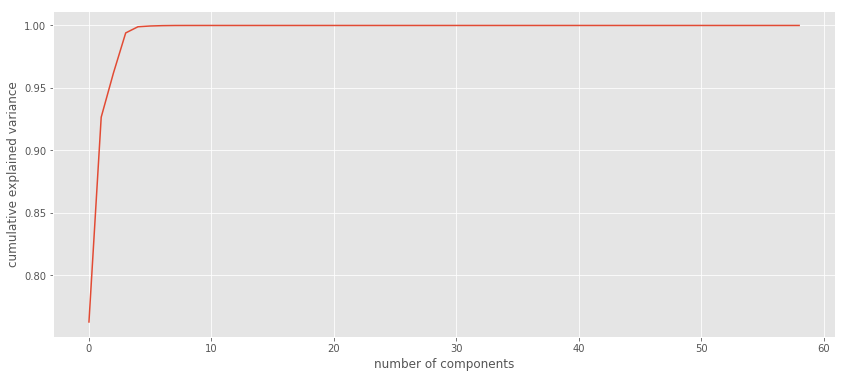

In [30]:
# Estimate number of components needed
pca = PCA().fit(df)
plt.figure(figsize=(14,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

[' timedelta' ' n_tokens_title' ' n_tokens_content' ' n_unique_tokens'
 ' n_non_stop_words' ' n_non_stop_unique_tokens' ' num_hrefs'
 ' num_self_hrefs' ' num_imgs' ' num_videos' ' average_token_length'
 ' num_keywords' ' data_channel_is_lifestyle'
 ' data_channel_is_entertainment' ' data_channel_is_bus'
 ' data_channel_is_socmed' ' data_channel_is_tech'
 ' data_channel_is_world' ' kw_min_min' ' kw_max_min' ' kw_avg_min'
 ' kw_min_max' ' kw_max_max' ' kw_avg_max' ' kw_min_avg' ' kw_max_avg'
 ' kw_avg_avg' ' self_reference_min_shares' ' self_reference_max_shares'
 ' self_reference_avg_sharess' ' weekday_is_monday' ' weekday_is_tuesday'
 ' weekday_is_wednesday' ' weekday_is_thursday' ' weekday_is_friday'
 ' weekday_is_saturday' ' weekday_is_sunday' ' is_weekend' ' LDA_00'
 ' LDA_01' ' LDA_02' ' LDA_03' ' LDA_04' ' global_subjectivity'
 ' global_sentiment_polarity' ' global_rate_positive_words'
 ' global_rate_negative_words' ' rate_positive_words'
 ' rate_negative_words' ' avg_positive_pol

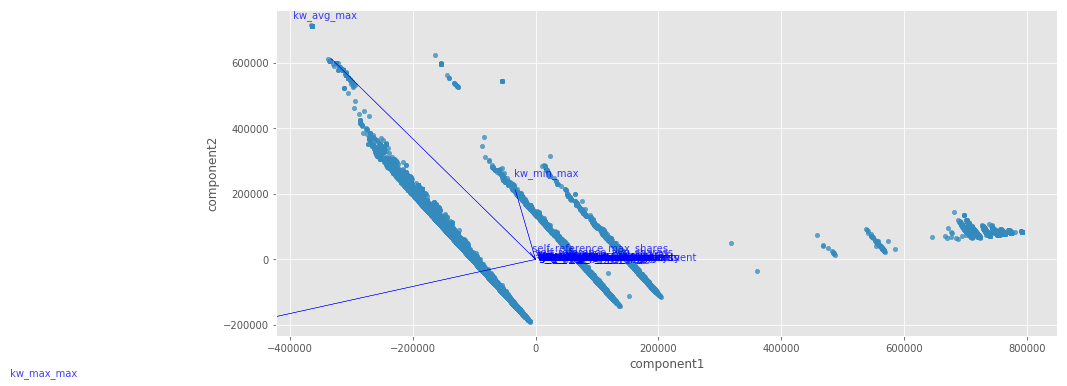

In [32]:
from sklearn.decomposition import PCA

# labels = ['red' if i== 1 else 'green' for i in df.share_rank]

scaleFeatures = True
pca = PCA(n_components=5, svd_solver='full')
pca.fit(df)

T = pca.transform(df)

print(df.columns.values)

plt.figure(figsize=(14,6))
ax = drawVectors(T, pca.components_, df.columns.values, plt, scaleFeatures)
T  = pd.DataFrame(T)
T.columns = ['component1', 'component2', 'component3', 'component4', 'component5']
T.plot.scatter(x='component1', y='component2', marker='o', alpha=0.75, ax=ax)

plt.show()